In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torch.autograd import Variable
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
vgg_19 = torchvision.models.vgg19_bn(pretrained=True)
# vgg_19.features

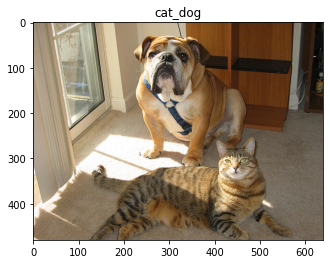

In [3]:
cat_dog = Image.open('../data/cat_dog.jpg')
%matplotlib inline
import matplotlib.pyplot as plt 
plt.imshow(cat_dog)
plt.axis('on') # 关掉坐标轴为 off
plt.title('cat_dog') # 图像题目
plt.show()

# cat_dog = (np.array(cat_dog)/255.).astype(np.float32)
# torchvision.io.read_image('/Users/yang/PycharmProjects/grad-cam/images/cat_dog.jpg')
# cat_dog.transpose(2,0,1).shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


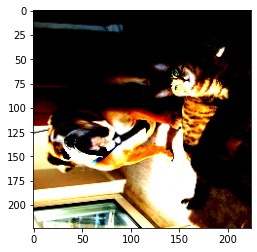

In [7]:
transform = transforms.Compose([
 transforms.RandomResizedCrop(224),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(), # 将图片转换为Tensor,归一化至[0,1]
 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
cat_dog_ten = transform(cat_dog).unsqueeze(0)

cat_dog_ten.shape
plt.imshow(cat_dog_ten.squeeze().transpose(2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


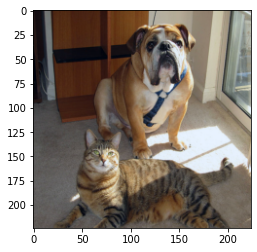

In [28]:
plt.imshow((cat_dog_ten.squeeze().transpose(2,0).transpose(1,0)+1.8439)/(2.6400+1.8439))


In [9]:
with open('input.pickle', 'wb') as f:
    pickle.dump(cat_dog_ten, f)

In [3]:
with open('input.pickle', 'rb') as f:
    cat_dog_ten = pickle.load(f)

In [4]:
out_feature_grads = []
in_feature_grads = []

def extract_layer_bias(module):
    # extract bias of each layer

    # for batchnorm, the overall "bias" is different
    # from batchnorm bias parameter.
    # Let m -> running mean, s -> running std
    # Let w -> BN weights, b -> BN bias
    # Then, ((x - m)/s)*w + b = x*w/s + (- m*w/s + b)
    # Thus (-m*w/s + b) is the effective bias of batchnorm
#     print(type(m))
    if isinstance(module, torch.nn.BatchNorm2d):
#         print('bn2')
        b = - (module.running_mean * module.weight
                / torch.sqrt(module.running_var + module.eps)) + module.bias
        return b.data
    elif module.bias is None:
        return None
    else:
        return module.bias.data
    
def _extract_layer_grads(module, in_grad, out_grad):
    # function to collect the gradient outputs
    # from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    if not module.bias is None:
        in_feature_grads.append(in_grad[0])
        out_feature_grads.append(out_grad[0])
        
in_layer_feat = []
out_layer_feat = []
in_layer_grad = []
out_layer_grad = []

def _extract_layer_feat(module, input, output):
    # function to collect the gradient outputs from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
#     if not module.bias is None:
    in_layer_feat.append(input[0])
    out_layer_feat.append(output[0])
    
    
def _extract_layer_grad(module, in_grad, out_grad):
    # function to collect the gradient outputs from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    in_layer_grad.append(in_grad[0])
    out_layer_grad.append(out_grad[0])
        

In [5]:
cam_layers = ['features.32','features.35','features.38','features.42','features.45', 'features.51']

bias_layers = []
biases = []
handlers = []

for name, m in vgg_19.named_modules():
    try:
        if name in cam_layers:
            handlers.append(m.register_forward_hook(_extract_layer_feat))
            handlers.append(m.register_backward_hook(_extract_layer_grad))
#         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.BatchNorm2d):
        if not ('fc' in name or 'classifier' in name or 'CBAM' in name) : 
#             print(m)
            b = extract_layer_bias(m)
            if (b is not None): 
                biases.append(b)
                bias_layers.append(name)
                    
#                 biases.append(_extract_layer_bias(m))
#                 print("bias:", _extract_layer_bias(m))
                m.register_backward_hook(_extract_layer_grads)
#                     m.register_forward_hook(_extract_layer_feat)
    except Exception as e:
        continue

# for name, m in model.named_modules():
#     if not ('fc' in name or 'classifier' in name) : 
#         b = self._extract_layer_bias(m)
#         if (b is not None): 
#             biases.append(b)
#             bias_layers.append(name)
           
print(bias_layers)
print("The number of layers with biases: ", len(biases))

['features.0', 'features.1', 'features.3', 'features.4', 'features.7', 'features.8', 'features.10', 'features.11', 'features.14', 'features.15', 'features.17', 'features.18', 'features.20', 'features.21', 'features.23', 'features.24', 'features.27', 'features.28', 'features.30', 'features.31', 'features.33', 'features.34', 'features.36', 'features.37', 'features.40', 'features.41', 'features.43', 'features.44', 'features.46', 'features.47', 'features.49', 'features.50']
The number of layers with biases:  32


In [6]:
vgg_19.eval()
loss = nn.CrossEntropyLoss()

# x = cat_dog_ten
input_im = Variable(cat_dog_ten.clone(), requires_grad=True)

x = vgg_19.features[0](input_im)

for i in range(1, 50):
    x = vgg_19.features[i](x)
    
# conv_out = Variable(x, requires_grad=True)
conv_out = x
x = vgg_19.features[50](conv_out)
x = vgg_19.features[51](x)
x = vgg_19.features[52](x)

# conv_out = Variable(x.clone(), requires_grad=True)

x = vgg_19.avgpool(x)
x = torch.flatten(x, 1)
output = vgg_19.classifier(x)

# output = vgg_19(cat_dog_ten)

In [7]:
output_softmax = nn.Softmax(dim=1)

outsoft = output_softmax(output)
outsoft.shape
print(torch.max(output, dim=1))
vgg_19.zero_grad()
# conv_out.zero_grad()

# torch.max(output, dim=1)[0].backward(retain_graph=True)

torch.max(outsoft, dim=1)[0].backward()

torch.return_types.max(
values=tensor([13.2548], grad_fn=<MaxBackward0>),
indices=tensor([243]))


In [8]:
# conv_out_grad = conv_out.grad
input_grad = input_im.grad
print(input_grad.shape)

torch.Size([1, 3, 224, 224])


In [9]:
print("Num of stored biases layers: ", len(bias_layers))
print("Num of stored gradient of biases layers: ", len(out_feature_grads))

ups = torch.nn.UpsamplingBilinear2d(size=(input_im.shape[-2], input_im.shape[-1]))
grad = input_im.grad.clone().cpu()# .clamp_min(0)
ingrad = grad.clone().abs()
# ingrad = grad.clamp_min(0)
# ingrad /= ingrad.sum()
# ingrad = grad_pp.abs()

# grad ++
first_derivative = output[0].max().exp().clone().cpu() * grad.clone().cpu()
feat = input_im.clone().cpu()
alpha = grad.pow(2) / (2 * grad.pow(2) + (grad.pow(3) * feat).sum(dim=(2, 3), keepdim=True))
grad_pp = alpha * first_derivative# (first_derivative.clamp_min(0))
grad_pp = grad_pp.clamp_min(0)

# grad cam
grad_cam = torch.zeros_like(input_im).clone().cpu()
L = len(cam_layers)
assert len(out_layer_grad) == L, print(len(out_layer_grad))

last_grad = out_layer_grad[0].clone().cpu()
last_feat = out_layer_feat[-1].clone().cpu()

T = (last_feat.clone() * last_grad.clone()).clamp_min(0).sum(dim=1, keepdim=True)
grad_cam += ups(T.clone().cpu())# .abs()
grad_cam = grad_cam.clamp_min(0)
grad_cam /= grad_cam.sum()


# grad cam ++ last
last_grad = out_layer_grad[0].clone().cpu()# .clamp_min(0)
last_feat = out_layer_feat[-1].clone().cpu()
first_derivative = output[0].max().exp().clone().cpu() * last_grad
alpha = last_grad.pow(2) / (2 * last_grad.pow(2) + (last_grad.pow(3) * last_feat).sum(dim=(2, 3), keepdim=True))
weight = alpha * (first_derivative.abs())

weight = weight.mean(dim=(2, 3), keepdim=True)
weight /= weight.sum()

grad_cam_pp = (last_feat * weight).sum(dim=1, keepdim=True)
grad_cam_pp = ups(grad_cam_pp)

# grad_cam_pp -= grad_cam_pp.min()
grad_cam_pp = grad_cam_pp.abs()
# grad_cam_pp = grad_cam_pp.clamp_min(0)
grad_cam_pp /= grad_cam_pp.sum()

# full grad
input_gradient = (input_im.grad * input_im)#.clamp_min(0)
full_grad = input_gradient.abs().clone().cpu()
full_grad -= full_grad.min()
full_grad /= full_grad.max()

L = len(bias_layers)
for i,l in enumerate(bias_layers):
    bias = biases[L-i-1].clone().cpu()
    if len(bias.shape) == 1:
        bias = bias.reshape(1,-1,1,1)
    bias = bias.expand_as(out_feature_grads[i])

    bias_grad = (out_feature_grads[i].clone().cpu()*bias).sum(dim=1, keepdim=True).abs()
    bias_grad -= bias_grad.min()
    bias_grad /= bias_grad.max()
    full_grad += ups(bias_grad)
    
# full_grad -= full_grad.min()
# full_grad = full_grad.abs()
# full_grad = full_grad.clamp_min(0)
full_grad /= full_grad.sum()

# vis_grad = [x, ingrad/ingrad.max(), grad_pp, stap_grad, ingrad*x_stdf, grad_cam, grad_cam_pp, full_grad]
# names = ['input', 'grad', 'grad_pp', 'stap_grad', 'grad*std', 'grad_cam', 'grad_cam++', 'full_grad']

Num of stored biases layers:  32
Num of stored gradient of biases layers:  32


/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


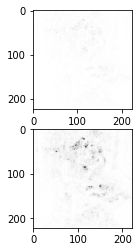

In [33]:
acc_input_gradient = input_gradient.clamp_min(0).clone().cpu().squeeze().mean(0)
ax= plt.subplot(2,1,1)
# acc_input_gradient = torch.nn.functional.max_pool2d(torch.tensor(acc_input_gradient).unsqueeze(0), kernel_size=3, stride=1, padding=1)

plt.imshow(acc_input_gradient.squeeze(0).detach().numpy(), cmap='Greys')

for i in range(L):
    this_grad = out_layer_grad[i].clone().cpu()
    this_feat = out_layer_feat[-1-i].clone().cpu()
#     print((this_grad*this_feat).shape)

    this_grad = ups(this_grad*this_feat).squeeze().mean(0)
#     print(this_grad.shape)
    
    acc_input_gradient += this_grad.clamp_min(0)

acc_input_gradient = torch.nn.functional.max_pool2d(torch.tensor(acc_input_gradient).unsqueeze(0), kernel_size=3, stride=1)
ax= plt.subplot(2,1,2)

plt.imshow(acc_input_gradient.squeeze(0).detach().numpy(), cmap='Greys')

tensor(8.4753e-05) tensor(0.)
tensor(0.5328, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


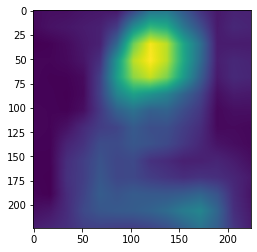

In [10]:
last_grad = out_layer_grad[0].clone().cpu()# .clamp_min(0)
last_feat = out_layer_feat[-1].clone().cpu()
first_derivative = output[0].max().exp().clone().cpu() * last_grad
# print(first_derivative)
# print(last_feat.max(), last_feat.min())


alpha = last_grad.pow(2) / (2 * last_grad.pow(2) + (last_grad.pow(3) * last_feat).sum(dim=(2, 3), keepdim=True)+1e-6)

print(last_grad.pow(2).max(), last_grad.pow(2).min())

weight = alpha * (first_derivative.abs())
print(alpha.max(), alpha.min())

weight = weight.mean(dim=(2, 3), keepdim=True)
weight /= weight.sum()

# print(weight)
grad_cam_pp = (last_feat * weight).sum(dim=1, keepdim=True)
grad_cam_pp = ups(grad_cam_pp)

# grad_cam_pp -= grad_cam_pp.min()
grad_cam_pp = grad_cam_pp.abs()
# grad_cam_pp = grad_cam_pp.clamp_min(0)
grad_cam_pp /= grad_cam_pp.sum()

plt.imshow(grad_cam_pp.squeeze().detach().numpy())

torch.Size([1, 1, 224, 224])

In [11]:
def calculate_outputs_and_gradients(inputs, model, target_label_idx):
    # do the pre-processing
    predict_idx = None
    gradients = []
    for s in inputs:
        s = Variable(s.cuda(), requires_grad=True)

        x = vgg_19.features[0](s)

        for i in range(1, 50):
            x = vgg_19.features[i](x)

        # conv_out = Variable(x, requires_grad=True)
        conv_out = x
        x = vgg_19.features[50](conv_out)
        x = vgg_19.features[51](x)
        x = vgg_19.features[52](x)

        # conv_out = Variable(x.clone(), requires_grad=True)

        x = vgg_19.avgpool(x)
        x = torch.flatten(x, 1)
        output = vgg_19.classifier(x)
        
        output = F.softmax(output, dim=1)

        if target_label_idx is None:
            target_label_idx = torch.argmax(output, 1).item()

        index = torch.ones((output.size()[0], 1)) * target_label_idx
        index = torch.tensor(index, dtype=torch.int64)
        if s.is_cuda:
            index = index.cuda()

        output = output.gather(1, index)
        # clear grad
        model.zero_grad()
        output.backward()

        gradient = s.grad
        gradients.append(gradient)

    gradients = torch.cat(gradients)

    return gradients, target_label_idx

In [12]:
# integrad

data = input_im.cuda()
baseline = 0. * data
steps = 20
scaled_inputs = [baseline + (float(i) / steps) * (data - baseline) for i in range(0, steps + 1)]

vgg_19.eval()
model = vgg_19.cuda()

grads, target_label_idx = calculate_outputs_and_gradients(scaled_inputs, model, target_label_idx=None)
grads = (grads[:-1] + grads[1:]) / 2.0
avg_grads = grads.mean(dim=0)

integrad = (data - baseline) * avg_grads
# integrad = integrad.clamp_min(0)
integrad = integrad.abs()
integrad = integrad.cpu()

/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [16]:
names = ['image', 'grad', 'grad_cam', 'grad_cam++', 'full_grad', 'integrad']
vis_grad_tmp = [input_im, ingrad, grad_cam, grad_cam_pp, full_grad, integrad]

vis_grad = [x.squeeze().detach().cpu().numpy().transpose() for x in vis_grad_tmp]

In [14]:
print(vis_grad[3])

[[3.7723821e-06 3.7412515e-06 3.7101213e-06 ... 7.5733342e-06
  7.7555760e-06 7.9378215e-06]
 [3.8182507e-06 3.7914738e-06 3.7646967e-06 ... 7.6936985e-06
  7.8776948e-06 8.0616937e-06]
 [3.8641192e-06 3.8416961e-06 3.8192725e-06 ... 7.8140620e-06
  7.9998135e-06 8.1855660e-06]
 ...
 [9.2041773e-06 9.2472683e-06 9.2903601e-06 ... 8.9602272e-06
  9.0389412e-06 9.1176571e-06]
 [9.1838956e-06 9.2250193e-06 9.2661448e-06 ... 8.5980164e-06
  8.6747596e-06 8.7515036e-06]
 [9.1636139e-06 9.2027722e-06 9.2419286e-06 ... 8.2358001e-06
  8.3105715e-06 8.3853438e-06]]


In [30]:
 for x in vis_grad:
        print(x.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224)
(224, 224, 3)
(224, 224, 3)


In [21]:
with open('image_grads.pickle', 'wb') as f:
    pickle.dump(vis_grad, f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


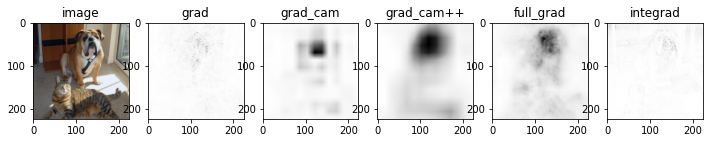

In [15]:
plt.figure(figsize=(12, 15))
# norm = matplotlib.colors.Normalize(vmin=-10., vmax=10.)
for i in range(len(vis_grad)):
    ax = plt.subplot(1, len(vis_grad), i+1)
    ax.set_title(names[i])
#     print(vis_grad[i].shape)
    if len(vis_grad[i].shape)==3 and i!=0 :
        im = ax.imshow(vis_grad[i].mean(axis=2).transpose(), cmap='Greys') #, norm=norm)
    elif i==0 :
        im = ax.imshow((vis_grad[i].swapaxes(1,0) +1.8439)/(2.6400+1.8439), cmap='Greys') #, norm=norm)
    else:
        im = ax.imshow(vis_grad[i].transpose(), cmap='Greys')
#     plt.colorbar(im)  # 显示颜色标尺


In [43]:
im_grad

tensor([[0.0125, 0.0000, 0.0004,  ..., 0.0000, 0.0125, 0.0000],
        [0.0060, 0.0166, 0.0206,  ..., 0.0034, 0.0070, 0.0000],
        [0.0157, 0.0106, 0.0071,  ..., 0.0173, 0.0000, 0.0008],
        ...,
        [0.0000, 0.0020, 0.0145,  ..., 0.0107, 0.0180, 0.0225],
        [0.0000, 0.0000, 0.0000,  ..., 0.0220, 0.0179, 0.0008],
        [0.0048, 0.0000, 0.0062,  ..., 0.0000, 0.0068, 0.0000]])

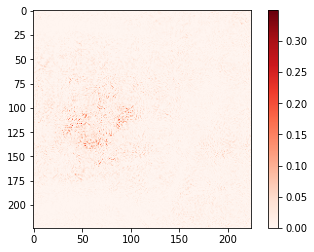

In [13]:
im_grad = input_grad[0].transpose(0,2)
im_grad = im_grad.clamp_min(0).mean(dim=2)

im = plt.imshow(im_grad, cmap='Reds')
plt.colorbar(im)

In [9]:
# def forward(self, x):
#     x = self.features(x)
#     x = self.avgpool(x)
#     x = torch.flatten(x, 1)
#     x = self.classifier(x)
#     return x

# vgg_19.zero_grad()
conv_out_grad_weight = conv_out_grad.sum(dim=(2,3), keepdim=True)
conv_out_grad_mul_weight = conv_out_grad * conv_out_grad_weight

Max and min is tensor(0.0062) tensor(0.0007)


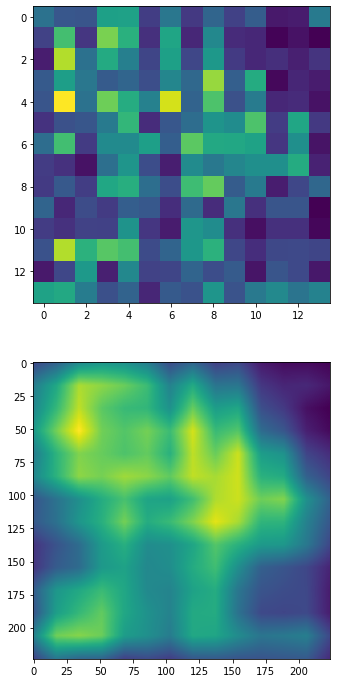

In [11]:
# vgg_19.features
avg_pool = nn.AvgPool2d(kernel_size=(3,3), stride=1, padding=1)

conv_out_grad_gap_relu = torch.nn.functional.relu(conv_out_grad_mul_weight.mean(dim=1, keepdim=True))
conv_out_grad_gap_relu_avg = avg_pool(conv_out_grad_gap_relu)

plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
_ = ax.imshow(conv_out_grad_gap_relu.squeeze().numpy())
upsample = nn.UpsamplingBilinear2d(size=(224,224))
conv_out_grad_gap_relu_up = upsample(conv_out_grad_gap_relu_avg)

# plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 2)

_ = ax.imshow(conv_out_grad_gap_relu_up.squeeze().numpy())
print('Max and min is', conv_out_grad_gap_relu_up.max(), conv_out_grad_gap_relu_up.min())

torch.Size([224, 224, 3]) torch.Size([224, 224])


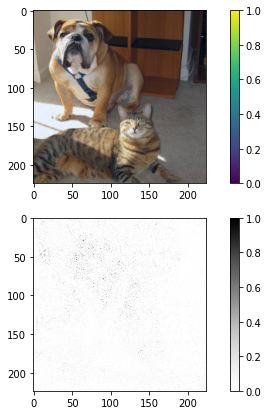

In [58]:
pdf = PdfPages('input_cam_im.pdf')

plt.figure(figsize=(8.5, 7))

ax = plt.subplot(2, 1, 1)
# im = plt.imshow((cat_dog_ten.squeeze().transpose(2,0).transpose(0,1)+1.8439)/(2.6400+1.8439))
input_im = cat_dog_ten.squeeze().transpose(2,0).transpose(0,1)
# input_im -= input_im.min()
# input_im /= input_im.max()
im = plt.imshow(input_im)

plt.colorbar(im)
ax = plt.subplot(2, 1, 2)
# im = plt.imshow((conv_out_grad_gap_relu_up.squeeze().numpy()-0.0006) /0.0053, cmap='Reds')
# plt.colorbar(im)

input_im_grad = im_grad.transpose(0,1)/im_grad.max()
im = plt.imshow(input_im_grad, cmap='Greys')
plt.colorbar(im)

filename = 'im_grad.pickle'

with open(filename, 'wb') as f:
    pickle.dump({"input_im":input_im.numpy(), "input_im_grad":input_im_grad.numpy(),}, f)

pdf.savefig()
pdf.close()

print(input_im.shape, input_im_grad.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max and min is  tensor(2.6400) tensor(-1.8610)


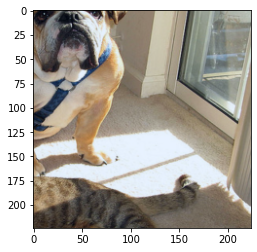

In [32]:
plt.imshow((cat_dog_ten.squeeze().transpose(2,0).transpose(0,1)+1.8439)/(2.6400+1.8439))

print('Max and min is ', cat_dog_ten.squeeze().max(), cat_dog_ten.squeeze().min())